<a href="https://colab.research.google.com/github/RERobbins/data_science_266_sandbox/blob/main/Embeddings_and_Vector_Databases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## OpenAI and Cohere Accounts and API Endpoints

OpenAI and Cohere provide large language models.  This notebook uses API endpoints from each.  

OpenAI provides free, rate-limited usage to its API endpoint for a three-month trial period.  In order to use the OpenAI API endpoint you will need an OpenAI API token.

Cohere provides free, rate-limited usage for learning and prototyping. In order to use Cohere you will need a Cohere API token.

If you don't already have an OpenAI API token you can get one by signing up for a free OpenAI account from the [OpenAI Signup page](https://platform.openai.com/signup?launch).  Once you have created your OpenAI account you can create a trial API key from the [OpenAI API page](https://platform.openai.com/account/api-keys).

If you don't already have a Cohere API token you can get one by signing up for a Cohere account from the [Cohere dashboard](https://dashboard.cohere.ai).  Once you have created your Cohere account you can create a trial API key from the [Cohere API Keys page](https://dashboard.cohere.ai/api-keys).

## Mount Google Drive

By default, the data you create in Google Colaboratory does not persist from session to session.  Each session runs in a virtual machine and when that machine goes away, so does your data.  If you want your data to persist, you must store it outside the virtual machine. Google Drive can be used for that purpose.  We use it later in this notebook to store the OpenAI and Cohere API keys.

In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


## Python-dotenv

`Python-dotenv` is a Python module that allows you to specify environment variables in traditional UNIX-like “.env” (dot-env) file within your Python project directory.

Environment variables are key-value pairs for the current user environment. They are generally set by the operating system and the current user-specific configurations.

`Python-dotenv` allows the user to work with API keys without exposing them to the outside world.

In [2]:
!pip install --quiet python-dotenv

## Add API Keys to .env File

The format of a .env file is simple: each line contains a single key-value pair, with the key and value separated by an equal sign (=). Here's an example:
```
DATABASE_URL=your_database_url
API_KEY=your_api_key
DEBUG=True
```
To use OpenAI and Cohere, we need to set the `OPENAI_API_KEY` and `COHERE_API_KEY` environment variables, which means the `.env` file should have lines that looks like:
```
OPENAI_API_KEY=your_openai_api_key_value
COHERE_API_KEY=your_cohere_api_key_value
```
One way to do that is to create or edit the `.env` file directly.  As with most Unix systems, file names that begin with a `.` in Google Drive are hidden from display, but you can still access them. For example, if you enter the name `.env` in the Google Drive search bar, you will be able to access your `.env` file (if it exists).

You can use the `append_key_to_env` helper function included below.  If used without arguments it will prompt the user for the value of an OpenAI API key and then the value of a Cohere API key and append each with the correct key name to the `.env` file in the root of the users Google Drive folder.  It will create the `.env` file if necessary.  You can provide an alternate list of key names and an alternate path to the function if you desire, but the defaults are fine for this notebook.

Once the OpenAI and Cohere APIs key have been stored in the `.env` file you should not need to do anything else with that file.  If either of your keys change you will need to update the `.env` file.

In [3]:
def append_key_to_env (env_file_path = '/content/drive/MyDrive/.env',
                           key_names = ['OPENAI_API_KEY', 'COHERE_API_KEY']):
  import getpass
  with open(env_file_path, 'a') as env_file:
    for key_name in key_names:
      key_value = getpass.getpass (f"Please enter the value for {key_name}: ")
      env_file.write(f'{key_name}={key_value}\n')

In [4]:
# Remove the # character in the line below and run if desired
# append_key_to_env()

## Load the API Keys

The following cell loads the OpenAI and Cohere API keys into the current environment.

In [5]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv('/content/drive/MyDrive/.env')
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
COHERE_API_KEY = os.environ["COHERE_API_KEY"]

# Langchain

LangChain is a framework designed to simplify the creation of applications using large language models. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

The examples in this notebook use LangChain rather than the underlying Python modules.  A description of LangChain is beyond the scope of this notebook.

In [6]:
!pip install --quiet langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.2 MB/s eta 0:00:00


# Embeddings

We will use OpenAI and Cohere large language models and embeddings, calculate cosine similarity and look at some heatmaps.

An overview of OpenAI models can be found [here](https://platform.openai.com/docs/models/overview) and an overciew of OpenAI embeddings can be found [here](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings).

An overview of Cohere models and embeddings can be found [here](https://docs.cohere.com/docs/models).

In [7]:
!pip install --quiet openai cohere tiktoken

import openai
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings.cohere import CohereEmbeddings

import cohere
from langchain.chat_models import ChatOpenAI
from langchain.llms import Cohere

from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.8 MB/s eta 0:00:00


In [8]:
def openai_token_count (text):
  embedding_model = OpenAIEmbeddings()
  openai_encoding = tiktoken.encoding_for_model(embedding_model.model)
  return len(openai_encoding.encode (text))

def cohere_token_count (text, model_name="command"):
  co = cohere.Client(COHERE_API_KEY)
  return len(co.tokenize(text=text, model=model_name))

def embeddings_similarity_heatmap(embeddings, figsize=None):
  if figsize is None:
    figsize = (len(embeddings), len(embeddings))
  similarity_matrix = cosine_similarity(embeddings)
  plt.figure(figsize=figsize)
  sns.heatmap(cosine_similarity (embeddings), cmap='viridis', annot=True, fmt=".3f")

Instantiate the embededing models.  

The default OpenAI model is `text-embedding-ada-002`, which is the preferred OpenAI embedding model for its GPT 3.5 and GPT 4 models.  
The maximum number of tokens for the OpenAI embedding model is 8192.

The default Cohere model is `embed-english-v2.0`  
The maximum number of tokens for the Cohere embedding model is `512`.

In [9]:
openai_embeddings_model = OpenAIEmbeddings ()
openai_embeddings_model.model

'text-embedding-ada-002'

In [10]:
cohere_embeddings_model = CohereEmbeddings(truncate='None')
cohere_embeddings_model.model

'embed-english-v2.0'

## Short Strings

Let's create OpenAI and Cohere embeddings from a series of strings, calculate pairwise cosine similarity and look at some heatmaps of the results.

Which embedding model do you think performs better on these strings?

In [11]:
strings = ["That movie was great.",
           "That film was wonderful.",
           "That movie was awesome.",
           "That film was rotten.",
           "That show was garbage.",
           "Grab a snapshot of the trash",
           "Take a picture of that rubbish.",
           "Film the garbage."]

openai_embeddings = openai_embeddings_model.embed_documents(strings)
cohere_embeddings = cohere_embeddings_model.embed_documents(strings)

In [12]:
[openai_token_count(string) for string in strings]

[5, 5, 5, 5, 5, 6, 7, 4]

In [13]:
[cohere_token_count(string) for string in strings]

[5, 5, 5, 5, 5, 6, 7, 4]

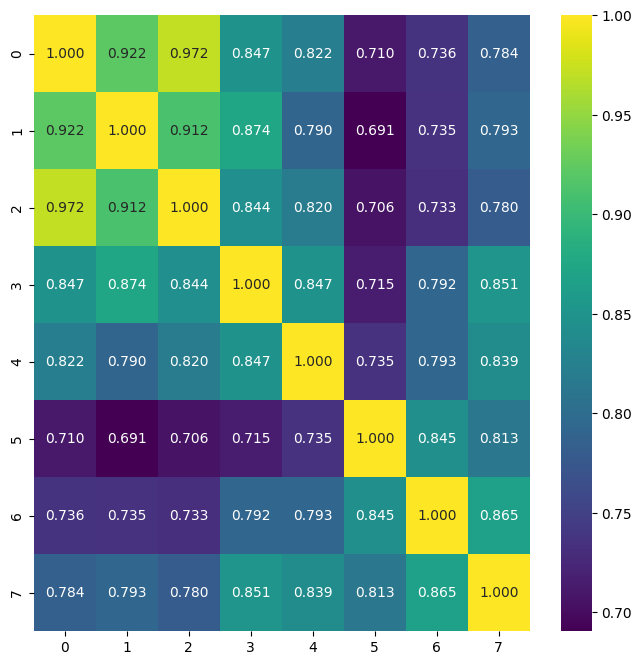

In [14]:
embeddings_similarity_heatmap (openai_embeddings)

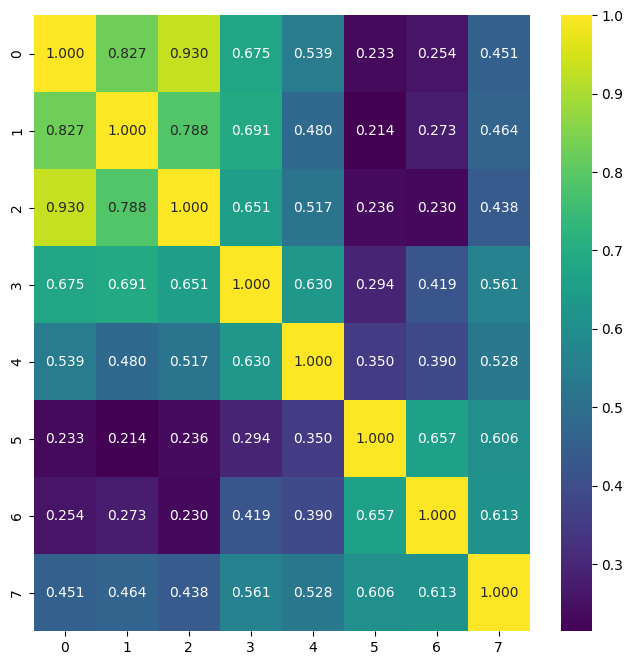

In [15]:
embeddings_similarity_heatmap (cohere_embeddings)

## Multilingual

We use embeddings to capture semantic similarity.  What happens when we look at the same text in several languages.  Will our embeddings reflect the semantic similarity?

Let's examine "Mary had a little lamb" in English, French and Spanish.

In [16]:
mary_english = """Mary had a little lamb,
Little lamb, little lamb,
Mary had a little lamb,
Its fleece was white as snow

Everywhere that Mary went,
Mary went, Mary went,
Everywhere that Mary went
The lamb was sure to go.

It followed her to school one day
School one day, school one day
It followed her to school one day
Which was against the rules.

It made the children laugh and play,
Laugh and play, laugh and play,
It made the children laugh and play
To see the lamb at school

And so the teacher turned it out,
Turned it out, turned it out,
And so the teacher turned it out,
But still it lingered near
"""

mary_french = """Mary avait un petit agneau,
Un petit agneau, un petit agneau,
Mary avait un petit agneau,
C'est toison était blanche comme neige, ouais

Partout, les Mary est allé,
Mary est allé, Mary est allé
Partout, les Mary est allé
Le petit agneau était sûr d'aller, ouais

Il la suivit à l'école un jour
A l'école un jour, à l'école un jour
Il la suivit à l'école un jour
Et enfreint la règle des enseignants.

Il a fait les enfants rient et jouent,
Rire et jouer, rire et jouer,
Il a fait les enfants rient et jouent
Pour voir un agneau à l'école

Et si l'enseignant il s'est avéré,
Il s'est avéré, il s'est avéré,
Et si l'enseignant il s'est avéré,
Mais toujours il resta près de
"""

mary_spanish = """Mary tenía un pequeño cordero,
Pequeño cordero, pequeño cordero
Mary tenía un pequeño cordero
Su lana era blanca como la nieve como la nieve blanca.

A cualquier lado que Mary iba
Mary iba, Mary iba
A cualquier lado que Mary iba
El cordero atrás yendo iba

Un día a la escuela la siguió
A la escuela un día, a la escuela un día
Un día a la escuela la siguió
Y eso estaba en contra de las reglas de la misma.

Hizó a los niños reír y jugar,
Reír y jugar, reír y jugar
Hizó a los niños reír y jugar
De verlo en la escuela estar.

Y entonces la maestra lo alejó,
Lo alejó, lo alejó
Y entonces la maestra lo alejó
Pero sin embargo cerca permanecía.
"""

mary = [mary_english, mary_french, mary_spanish]
mary_openai_embeddings = openai_embeddings_model.embed_documents(mary)
mary_cohere_embeddings = cohere_embeddings_model.embed_documents(mary)

In [17]:
[openai_token_count(string) for string in mary]

[143, 212, 218]

In [18]:
[cohere_token_count(string) for string in mary]

[160, 284, 260]

The OpenAI embeddings for the three renditions are similar.

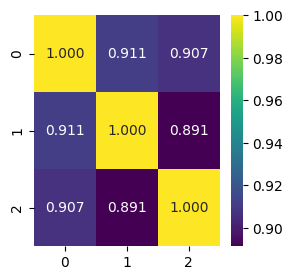

In [19]:
embeddings_similarity_heatmap (mary_openai_embeddings)

The Cohere embeddings are not similar.

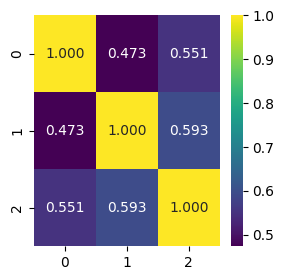

In [20]:
embeddings_similarity_heatmap (mary_cohere_embeddings)

Cohere has a separate embedding model that provides multilingual embedding suport.  Unlike the `embed-english-v2.0` model which has a 512 token maximum, the `embed-multilingual-v2.0` model has a 256 token maximum.  See [Cohere multilingual language models](https://docs.cohere.com/docs/multilingual-language-models)

The default Cohere embedding model is, by intent, English only.  The Cohere multilingual model is much stronger on this example.

Consider how the OpenAI embedding model compares to the Cohere multilingual embedding model.

In [21]:
cohere_multilingual_embeddings_model = CohereEmbeddings(model="embed-multilingual-v2.0", truncate='None')
cohere_multilingual_embeddings_model

CohereEmbeddings(client=<cohere.client.Client object at 0x799535000250>, async_client=<cohere.client_async.AsyncClient object at 0x799535000ca0>, model='embed-multilingual-v2.0', truncate='None', cohere_api_key=None)

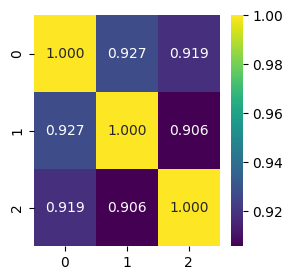

In [22]:
mary_cohere_multilingual_embeddings = cohere_multilingual_embeddings_model.embed_documents(mary)
embeddings_similarity_heatmap (mary_cohere_multilingual_embeddings)

Let's add "Three Blind Mice", in English and compare the OpenAI and Cohere multilingual embeddings

In [23]:
mice = """Three blind mice, three blind mice
See how they run, see how they run
They all run away from the farmer's wife
Then into a space ship to take a ride
Did you ever see such a sight in your life
As three blind mice?

Three blind mice, three blind mice
Crash on the moon, crash on the moon
The moon was covered in cheese so high
And nobody knew the reason why
Did you ever see such a sight in your life
As three blind mice?

Three blind mice, three blind mice
With full tummies, with full tummies
All of them ate too much cheese that night
With little moon left after every bite
Did you ever see such a sight in your life
As three blind mice?"""

In [24]:
openai_token_count(mice)

159

In [25]:
cohere_token_count(mice)

160

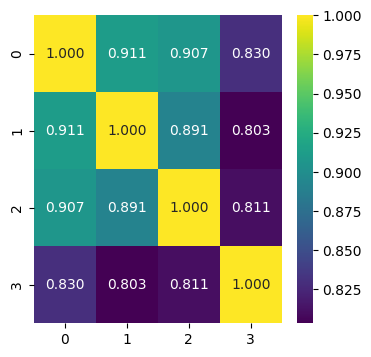

In [26]:
mary_mice_openai_embeddings = openai_embeddings_model.embed_documents(mary + [mice])
embeddings_similarity_heatmap (mary_mice_openai_embeddings)

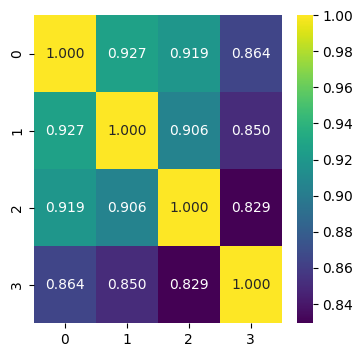

In [27]:
mary_mice_cohere_multilingual_embeddings = cohere_multilingual_embeddings_model.embed_documents(mary + [mice])
embeddings_similarity_heatmap (mary_mice_cohere_multilingual_embeddings)

What happens when we add some music lyrics to the mix.

In [28]:
bohemian = """I see a little silhouetto of a man
Scaramouche, Scaramouche, will you do the Fandango?
Thunderbolt and lightning, very, very frightening me
(Galileo) Galileo, (Galileo) Galileo, Galileo Figaro, magnifico
But I'm just a poor boy, nobody loves me
He's just a poor boy from a poor family
Spare him his life from this monstrosity"""

In [29]:
openai_token_count(bohemian)

97

In [30]:
cohere_token_count(bohemian)

92

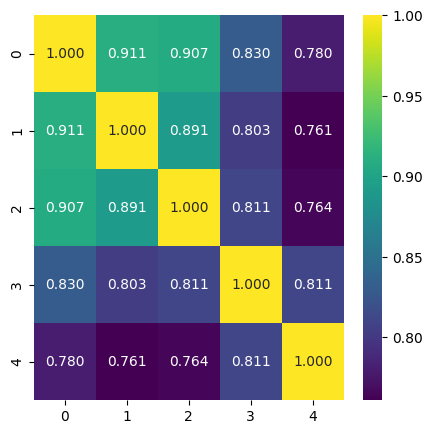

In [31]:
amalgam_openai_embeddings = openai_embeddings_model.embed_documents(mary + [mice, bohemian])
embeddings_similarity_heatmap (amalgam_openai_embeddings)

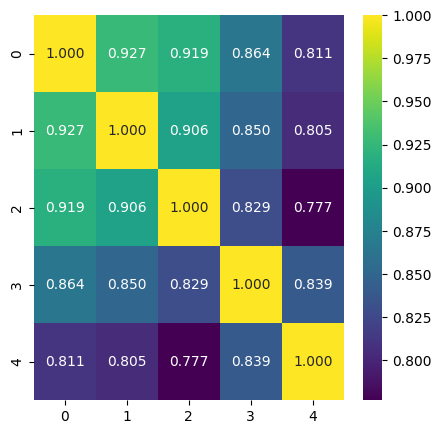

In [32]:
amalgam_cohere_multilingual_embeddings = cohere_multilingual_embeddings_model.embed_documents(mary + [mice, bohemian])
embeddings_similarity_heatmap (amalgam_cohere_multilingual_embeddings)

# Vector Databases

## Introduction

A vector database, also known as a vector search engine or similarity search database, is a type of database that specializes in storing and retrieving high-dimensional vectors efficiently.  The embeddings we have been using are high-dimensional vectors.

In the context of question answering tasks, vector databases can be particularly useful for tasks like semantic search, where you want to find documents or data points that are semantically similar to a given query.

Traditional relational databases are not well-suited for efficiently querying and retrieving semantically similar data. Vector databases, on the other hand, are designed to handle similarity-based searches efficiently.

Vector databases are an essential component of modern natural language processing solutions that are built to apply the generative capabilities of large language models to data collections.  This approach is called retrieval augmented generation or "RAG".

RAG is used in tasks like question answering.  With RAG, a retrieval component first selects a set of relevant documents or passages from a larger corpus, and then a generation component generates the final response based on the selected information. This approach aims to combine the accuracy of retrieval with the flexibility of generation.

We will use Chroma, a simple vector database and explore some of the most important concepts.

Up to this point in the notebook we have experimented with several different embedding models.  The embeddings we use with a large language model need to be suitable for use with that model.  For example, the OpenAI embeddings we have used so far are compatible with both `gpt-3.5` and `gpt-4` models.  We have experimented with two different Cohere embedding models, engligh and multi-lingual.  These are compatible with Cohere's current `command` model.

From this point on in the notebook, we will stick to a single large language model and a single embedding model.  We will also select a single embedding model.  OpenAI trial accounts expire after three months and provide access to `gpt-3.5` but not `gpt-4`.  Paid OpenAI accounts permit use of `gpt-4` as well and do not expire.  Cohere trial accounts do not expire, but the API rate limiting is more significant than OpenAI trial account rate limiting.

If you set `LLM_SOURCE` to `"OpenAI"` you will use the `openai_embeddings_model`.  If you set `LLM_SOURCE` to `"Cohere"` you need to select whether you want `cohere_embeddings_model` (which accomodates more tokens but it limited to English) or `cohere_multilingual_embeddings_model`.

If you set `LLM_SOURCE` to `"OpenAI"` and your OpenAI license is a trial license, you will not have access to `gpt-4`.  However, if you have a paid OpenAI license, you can move from `gpt-3.5-turbo` to `gpt-4`.  If you set `LLM_SOURCE` to `"Cohere"` you will use Cohere's `command` large language model.

The results in most of the examples below will vary with your choices.


In [33]:
LLM_SOURCE="Cohere"  #set this to either "OpenAI" or "Cohere"

if LLM_SOURCE=="OpenAI":
  embeddings_model=openai_embeddings_model
  llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
# llm = ChatOpenAI(model="gpt-4", temperature=0)

if LLM_SOURCE=="Cohere":
  embeddings_model=cohere_embeddings_model
# embeddings_model=cohere_multilingual_embeddings_model
  llm = Cohere(model="command", temperature=0)

In [34]:
!pip install --quiet chromadb
from langchain.vectorstores import Chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━

## Document Chunking

Document chunking, also known as text segmentation or document splitting, refers to the process of breaking down large documents or pieces of text into smaller, manageable segments before feeding them to large language models. There are several reasons why chunking is important when working with these models.

Chunking documents when working with large language models is essential to overcome input limitations, improve performance, manage costs, ensure complete responses, maintain contextual coherence, and guide the model's attention effectively. It allows you to make the most out of these powerful models when dealing with lengthy or complex text documents.

In the following code cells, we will download several corporate privay policies from the web.  We will use document loaders specific to `pdf` files or `urls` as the case may be.

We the use LangChain's `RecursiveCharacterTextSplitter` to chunk each document.  See the relevant [LangChain documentation](https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/recursive_text_splitter).

We add a piece of metadata that identifies the relevant organization for each chunk.  We discuss this in greater detail below.

In [35]:
!pip install --quiet pypdf unstructured

import textwrap
from langchain.document_loaders import PyPDFLoader, UnstructuredURLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.0/271.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.0 MB/s eta 0:00:00


In [39]:
import pandas as pd

policy_data = [
    ("Apple", "Privacy Policy", "https://www.apple.com/legal/privacy/pdfs/apple-privacy-policy-en-ww.pdf"),
    ("Google", "Privacy Policy", "https://static.googleusercontent.com/media/www.google.com/en//intl/en/policies/privacy/google_privacy_policy_en.pdf"),
    ("Meta", "Privacy Policy", "https://about.fb.com/wp-content/uploads/2022/07/Privacy-Within-Metas-Integrity-Systems.pdf"),
    ("TikTok", "Privacy Policy", "https://www.tiktok.com/legal/page/us/privacy-policy/en"),
    ("Threads", "Privacy Policy", "https://terms.threads.com/privacy-policy")
]

columns = ['organization', 'title', 'url']

policy_df = pd.DataFrame(policy_data, columns=columns)

In [40]:
def get_chunks (url, organization, title, chunk_size=1000, chunk_overlap=100):

    """
    This function takes a url to an organization's web page, organization name,
    and document title and returns chunks constructed from the target url.
    The function adds the url, the organization name and the document title
    as metadata to the chunks.

    Parameters:
    url (string): Target page.
    organization (string): Organization name.
    title: Document title.
    chunk_size (int, optional): Chunk size, default is 1000 characters.
    chunk_overlap (int, optional): Chunk overlap, default is 10 characters.

    Returns:
    list of chunks
    """

    # Use PyPDFLoader for pdf targets, otherwise UnstructuredURLLoader
    if os.path.splitext(url)[1] == ".pdf":
      loader = PyPDFLoader(url)
    else:
      loader = UnstructuredURLLoader(urls=[url])

    # Load the documents and add organization metadata field.
    # Increment page count metadata by one so it's not zero-based.

    documents = loader.load()
    for document in documents:
      metadata = document.metadata
      metadata['url'] = url
      metadata['organization'] = organization
      metadata['title'] = title
      if metadata.get('page', None) is not None:
        metadata['page'] += 1

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size,
                                                   chunk_overlap=chunk_overlap)

    return text_splitter.split_documents(documents)

def explore_documents (documents):
  block_indent = "   "
  metadata=documents[0].metadata
  content=documents[0].page_content[:200] + ". . ."
  print(f"{metadata['organization']} {metadata['title']} {len(documents)} chunks")
  print("Truncated First chunk:")
  print(textwrap.fill(content,
                      initial_indent=block_indent,
                      subsequent_indent=block_indent,
                      replace_whitespace=True))
  print()

In [41]:
chunks=[]

for row in policy_df.itertuples(index=False):
  policy_chunks = get_chunks(row.url, row.organization, row.title)
  explore_documents(policy_chunks)
  chunks += policy_chunks

Apple Privacy Policy 33 chunks
Truncated First chunk:
   Apple Privacy Policy Apple’s Privacy Policy describes how Apple
   collects, uses, and shares your personal data. Updated December 22,
   2022 In addition to this Privacy Policy, we provide data and
   privacy. . .

Google Privacy Policy 32 chunks
Truncated First chunk:
   Privacy Policy Last modified: December 18, 2017 ( view archived
   versions ) (The hyperlinked examples are available at the end of
   this document.) There are many different ways you can use our
   services . . .

Meta Privacy Policy 78 chunks
Truncated First chunk:
   July 2022   Privacy within Meta’s   Integrity Systems   Why user
   rights are at the center   of our safety and security approach. . .

TikTok Privacy Policy 41 chunks
Truncated First chunk:
   How TikTok is supporting our community through COVID-19  U.S.
   Privacy Policy  Last updated: May 22, 2023  This Privacy Policy
   applies to TikTok services (the “Platform”), which include TikTok
   a

## Create Vector Database from Chunked Documents

We will use the `get_chunks` helper function we used above to assemble a list of all the chunks and then pass that list to a function that instantiates a vector database from those chunks and an embedding model.

In [42]:
# There are 210 chunks in all.

len(chunks)

210

In [43]:
# Let's take a look at a couple of chunks.

chunks[22]

Document(page_content="To exercise privacy rights for your child's information, visit the Apple Data and Privacy page at privacy.apple.com and sign in to their account. Cookies and Other Technologies Apple’s websites, online services, interactive applications, and advertisements may use “cookies” and other technologies such as web beacons. These technologies help us to better understand user behavior including for security and fraud prevention purposes, tell us which parts of our websites people have visited, and facilitate and measure the effectiveness of advertisements and web searches. •Communications Cookies. These cookies are used to enable network traffic to and from Apple’s systems, including by helping us detect any errors. •Strictly Necessary Cookies. These cookies are set as required to provide a specific feature or service that you have accessed or requested. For example, they allow us to display our websites in the proper format and language, to authenticate and verify your

In [44]:
chunks[128]

Document(page_content='Other Policies, Meta Transparency Center,  https://transparency.fb.com/policies/other-policies  . \n 13.  “Publishing our Internal Enforcement Guidelines and Expanding our Appeal Process,” Meta \n Newsroom (April 24, 2018), \n https://about.fb.com/news/2018/04/comprehensive-community-standards/  . \n 14.  Community Standards, “Bullying and Harassment,” \n https://transparency.fb.com/policies/community-standards/bullying-harassment/  . \n 15.  Instagram, Community Guidelines, \n https://www.facebook.com/help/instagram/477434105621119  . \n 16. “Since 2016, the strategy of Integrity has been “  remove, reduce, and inform  ” to manage \n problematic content across the Facebook family of apps. This involves removing content that \n violates our policies, reducing the spread of problematic content that does not violate our \n policies and informing people with additional information so they can choose what to click, read', metadata={'source': '/tmp/tmpfdblozk5/tmp.pdf

In [45]:
vectordb = Chroma.from_documents(documents=chunks, embedding=embeddings_model)
assert vectordb._collection.count() == len(chunks)

## Query the Vector Database

A similarity search that returns the four vectors closest to the query by default.

In [46]:
query = "Does Apple sell my personal data?"
results = vectordb.similarity_search(query)
[result.metadata['organization'] for result in results]

['Apple', 'Apple', 'Apple', 'Apple']

Examine the first result in the list.  It looks to be responsive to the question.

In [47]:
print(textwrap.fill(results[0].page_content))

Apple’s Sharing of Personal Data Apple may share personal data with
Apple-affiliated companies, service providers who act on our behalf,
our partners, developers, and publishers, or others at your direction.
Apple does not share personal data with third parties for their own
marketing purposes.  •Service Providers. Apple may engage third
parties to act as our service providers and perform certain tasks on
our behalf, such as processing or storing data, including personal
data, in connection with your use of our services and delivering
products to customers. Apple service providers are obligated to handle
personal data consistent with this Privacy Policy and according to our
instructions. •Partners. At times, Apple may partner with third
parties to provide services or other offerings. For example, Apple
financial offerings like Apple Card and Apple Cash are offered by
Apple and our partners. Apple requires its partners to protect your
personal data. •Developers and Publishers from Whom


Increase the number of results to 10.

In [48]:
query = "Does Apple sell my personal data?"
results = vectordb.similarity_search(query, k=10)
[result.metadata['organization'] for result in results]

['Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple']

When we ask about Apple's use of cookies, there's a problem.  We get responses that don't relate to Apple.

Can you imagine why?

In [49]:
query = "Does Apple use cookies?"
results = vectordb.similarity_search (query, k=10)
[result.metadata['organization'] for result in results]

['Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Google']

The first result looks good.  It talks about Apple and the fact that Apple uses cookies.

In [50]:
print(textwrap.fill(results[0].page_content))

To exercise privacy rights for your child's information, visit the
Apple Data and Privacy page at privacy.apple.com and sign in to their
account. Cookies and Other Technologies Apple’s websites, online
services, interactive applications, and advertisements may use
“cookies” and other technologies such as web beacons. These
technologies help us to better understand user behavior including for
security and fraud prevention purposes, tell us which parts of our
websites people have visited, and facilitate and measure the
effectiveness of advertisements and web searches. •Communications
Cookies. These cookies are used to enable network traffic to and from
Apple’s systems, including by helping us detect any errors. •Strictly
Necessary Cookies. These cookies are set as required to provide a
specific feature or service that you have accessed or requested. For
example, they allow us to display our websites in the proper format
and language, to authenticate and verify your transactions, and to


Now lets look at any other responses.  Did we ask for too many results?  Are there chunks that talk about cookies but don't mention the company?

In [51]:
for result in results:
  if result.metadata['organization'] != "Apple":
    print("Organization: ", result.metadata['organization'])
    print(textwrap.fill(result.page_content))
    print()

Organization:  Google
We use information collected from cookies and other technologies, like
pixel tags , to improve your user experience  and the overall quality
of our services. One of the products we use to do this on our own
services is Google Analytics. For example, by saving your language
preferences, we’ll be able to have our services appear in the language
you prefer. When showing you tailored ads, we will not associate an
identifier from cookies or similar technologies with sensitive
categories , such as those based on race, religion, sexual orientation
or health. Our automated systems analyze your content (including
emails) to provide you personally relevant product features, such as



When we processed the source documents and split them into chunks, we added the name of the organization for the policy as metadata.  We can use that metadata as a filter.  In our example below, the filter is very simple, we merely indicate that the organization field needs to be `Apple`.  When we add that parameter, the results are limited to Apple embeddings.

In [52]:
results = vectordb.similarity_search (query, filter = {'organization':'Apple'}, k=10)
[result.metadata['organization'] for result in results]

['Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple']

Our next query only references "the company" and not any specific company.  The results relate to several of the companies.

In [53]:
query = "Does the company sell private data?"
results = vectordb.similarity_search (query, k=10)
[result.metadata['organization'] for result in results]

['Threads',
 'Google',
 'Google',
 'TikTok',
 'Apple',
 'Threads',
 'Google',
 'TikTok',
 'Threads',
 'TikTok']

We can use the filter to indicate that we care about Google only.

In [54]:
query = "Does the company sell private data?"
results = vectordb.similarity_search (query, filter = {'organization':'Google'}, k=10)
[result.metadata['organization'] for result in results]

['Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google']

In [55]:
print(textwrap.fill(results[5].page_content))

information in order to process it for us, and who are subject to
strict contractual confidentiality obligations and may be  disciplined
or terminated if they fail to meet these obligations. When this
Privacy Policy applies Our Privacy Policy applies to all of the
services offered by Google LLC and its affiliates, including YouTube,
services Google provides on Android devices, and services offered on
other sites (such as our advertising services), but excludes services
that have separate privacy policies that do not incorporate this
Privacy Policy. Our Privacy Policy does not apply to services offered
by other companies or individuals, including products or sites that
may be displayed to you in search results, sites that may include
Google services, or other sites linked from our services. Our Privacy
Policy does not cover the information practices of other companies and
organizations who advertise our services, and who may


# Answering Questions With Retrieval Augmented Generation

Now that we have some familiarity with vector databases, lets use ours, together with a large language model, to answer questions about the five privacy policies we have been working with.  We will continue to rely on the LangChain framework.

In [56]:
!pip install --quiet transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.5 MB/s eta 0:00:00


## Prompting a Model

[reword] Before we introduce working with the vector database, let's experiment with a simple model prompt.  We will pass a string to Cohere's `command` model, which is its default generative model, and see how it responds.

The responses are based on information the model was trained on.  We don't know if it they are accurate.  Sources are not presented.  The response for Threads doesn't seem to relate to the Threads social media platform either.

In [ ]:
### Add this section back -- or not.

## LangChain PromptTemplate

A prompt template is a reproducible way to generate prompts. It's essentially a text string that can take in a set of parameters from the end user and generate a prompt accordingly.  Let's shift to LangChain chains by using the simplest of templates.

The responses are not the same as before.  The substance of each has shifted too.

Remember, the model is generating responses based on its training data.

In [57]:
from langchain import PromptTemplate, LLMChain

In [58]:
template = """Question: {question} Answer:"""
prompt = PromptTemplate(
    template=template,
    input_variables=['question']
)

chain = LLMChain(prompt=prompt, llm=llm)

In [59]:
query = "Does Apple sell my personal data?"
print(textwrap.fill(chain.run(query)).strip())

Apple does not sell your personal data. However, it does collect and
use data in ways that may be considered a sale under certain laws. For
example, Apple may share your data with third parties for marketing
purposes, or it may use your data to improve its products and
services. In these cases, Apple may be considered to have sold your
data even though it does not receive any direct financial
compensation.


In [60]:
query = "Does Threads sell my personal data?"
print(textwrap.fill(chain.run(query)).strip())

Threads does not sell your personal data. Threads is a social media
platform that allows users to share their personal experiences and
connect with others. Threads does not share or sell user data to third
parties.


## LangChain RetrievalQA Chain

Now we introduced our vector database and the LangChain Retrieval QA chain, a chain for question answering against a database of information.  This time, the response for Apple mentions the privacy policy.  It would be reassuring if sources were identified.

In [61]:
from langchain.chains import RetrievalQA

chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
    )

In [62]:
query = "Does Apple sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

No, Apple does not sell your personal data. Apple's privacy policy
explicitly states that they do not share personal data with third
parties for their own marketing purposes. However, it is important to
note that Apple may share personal data with Apple-affiliated
companies, service providers, partners, developers, and publishers, or
others at your direction. Additionally, Apple may disclose information
about you if required by law or if there is a lawful basis for doing
so.


In [63]:
query = "Does Threads sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

No, Threads does not sell your personal data. The company has a
privacy policy in place that outlines how they collect, use, and share
personal data. The policy states that they will not sell or transfer
personal data to third parties unless it is necessary to provide and
improve their services, comply with applicable law, or as part of a
merger, acquisition, or sale of assets.


We can build our own prompt to be used in the QA chain.  Our prompt will be based on the PromptTemplate we looked at above.

In [64]:
template = """Use the following pieces of context to answer the question at the end.
Your answer should be as concise as possible and not more than three sentences.
If you don't know the answer, just say that you don't know.

{context}

Question: {question}

Answer:"""

prompt = PromptTemplate(template=template,
                        input_variables=["context", "question"]
                        )

chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type_kwargs={"prompt": prompt}
)

In [65]:
query = "Does Apple sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

Apple does not sell your personal data, including as "sale" is defined
in Nevada and California. Apple also does not "share" your personal
data as that term is defined in California.


In [66]:
query = "Does Threads sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

Threads does not sell your personal data. However, Threads may share
your personal data with third parties for business purposes, such as
providing customer support, analyzing how you interact and engage with
Threads, or obtaining information to generate leads and create user
profiles. Threads may also share your personal data with vendors,
social media networks, and other third parties for commercial or
business purposes.


Get source documents.

In [67]:
chain = RetrievalQA.from_chain_type(llm=llm,
                                 chain_type="stuff",
                                 retriever=vectordb.as_retriever(search_type="mmr", search_kwargs={'fetch_k': 30}), \
                                 return_source_documents=True)

In [68]:
query = "Does Apple sell my personal data?"
result = chain({"query": query})

In [69]:
print(textwrap.fill(result['result'].strip()))

Apple does not sell your personal data to third parties for their own
marketing purposes. However, Apple may share your personal data with
Apple-affiliated companies, service providers, partners, developers,
and publishers, or others at your direction. Apple may also share your
personal data with third parties for legal obligations or business
transfers.


In [70]:
[source.metadata['organization'] for source in result['source_documents']]

['Apple', 'Apple', 'Apple', 'Threads']

Self-querying retriever.

A self-querying retriever is one that, as the name suggests, has the ability to query itself. Specifically, given any natural language query, the retriever uses a query-constructing LLM chain to write a structured query and then applies that structured query to it's underlying VectorStore. This allows the retriever to not only use the user-input query for semantic similarity comparison with the contents of stored documented, but to also extract filters from the user query on the metadata of stored documents and to execute those filters.

The following code does not yet work with Cohere.


In [73]:
### The examples in this portion of the notebook do not work with Cohere.
### If LLM_SOURCE is set to Cohere we attempt to rebuild the vector database
### with OpenAI embeddings and use an OpenAI model.

if LLM_SOURCE=="Cohere":
  embeddings_model=openai_embeddings_model
  llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
# llm = ChatOpenAI(model="gpt-4", temperature=0)
  vectordb.delete_collection()
  vectordb = Chroma.from_documents(documents=chunks, embedding=embeddings_model)
  assert vectordb._collection.count() == len(chunks)

In [74]:
!pip install --quiet lark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 2.4 MB/s eta 0:00:00


In [109]:
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

metadata_field_info=[
    AttributeInfo(
        name="organization",
        description="The organization, company, entity or institution that the document relates to",
        type="string or list[string]",
    ),
    AttributeInfo(
        name="title",
        description="The title of the document",
        type="string",
    ),
    AttributeInfo(
        name="url",
        description="The url for the document",
        type="string",
    ),
]
document_content_description = "A policy"
retriever = SelfQueryRetriever.from_llm(llm, vectordb, document_content_description, metadata_field_info, verbose=True, enable_limit=True)

In [105]:
documents = retriever.get_relevant_documents("Do companies use cookies?")

query='companies use cookies' filter=None limit=None


In [106]:
documents = retriever.get_relevant_documents("Does Google use cookies?")

query='Google cookies' filter=Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Google') limit=None


In [107]:
documents = retriever.get_relevant_documents("Do Apple or Microsoft use cookies?")

query='cookies' filter=Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Apple'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Microsoft')]) limit=None


In [111]:
documents = retriever.get_relevant_documents("Which comanies use cookies?")

/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:279: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


query='cookies' filter=None limit=None


In [112]:
documents

[Document(page_content='use cookies, pixel tags and other technologies to serve and offer relevant ads.', metadata={'organization': 'Google', 'page': 4, 'source': '/tmp/tmpz338r8pm/tmp.pdf', 'title': 'Privacy Policy', 'url': 'https://static.googleusercontent.com/media/www.google.com/en//intl/en/policies/privacy/google_privacy_policy_en.pdf'}),
 Document(page_content='Cookies. We and our service providers and business partners use cookies and other similar technologies (e.g., web beacons, flash cookies, etc.) (“Cookies”) to automatically collect information, measure and analyze how you use the Platform, including which pages you view most often and how you interact with content, enhance your experience using the Platform, improve the Platform, provide you with advertising, and measure the effectiveness of advertisements and other content. We and our partners also use Cookies to promote the Platform on other platforms and websites. Cookies enable the Platform to provide certain features 

In [113]:
retriever.get_relevant_documents("Tell me two companies that use cookies?")

query='cookies' filter=None limit=2


[Document(page_content='use cookies, pixel tags and other technologies to serve and offer relevant ads.', metadata={'organization': 'Google', 'page': 4, 'source': '/tmp/tmpz338r8pm/tmp.pdf', 'title': 'Privacy Policy', 'url': 'https://static.googleusercontent.com/media/www.google.com/en//intl/en/policies/privacy/google_privacy_policy_en.pdf'}),
 Document(page_content='Cookies. We and our service providers and business partners use cookies and other similar technologies (e.g., web beacons, flash cookies, etc.) (“Cookies”) to automatically collect information, measure and analyze how you use the Platform, including which pages you view most often and how you interact with content, enhance your experience using the Platform, improve the Platform, provide you with advertising, and measure the effectiveness of advertisements and other content. We and our partners also use Cookies to promote the Platform on other platforms and websites. Cookies enable the Platform to provide certain features 

In [108]:
documents = retriever.get_relevant_documents("Do companies use cookies?  Do not tell me about what Google does.")

OutputParserException: ignored